In [66]:
import os
import geopandas
import json
import pandas as pd 
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from geopy import distance
from shapely.geometry import Point
import geocoder
import pickle
import joblib 

In [67]:
print(geopandas.__version__)

0.6.2


In [2]:
os.chdir('..')

In [3]:
test = pd.read_csv('ENG_DATA/SELECTED/05-01_cat_transformed_test.csv', index_col = [0])
train = pd.read_csv('ENG_DATA/SELECTED/05-01_cat_transformed_train.csv', index_col = [0])

In [8]:
x_test = test.drop(columns = ['sale_price'])
y_test = test["sale_price"]
x_train = train.drop(columns = ['sale_price'])
y_train = train["sale_price"]

# Run Cross-Validation on Tree Parameters

In [7]:
## CREDIT: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [9]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [10]:
rf_random.best_params_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

# Building Random Forests with and without Location Data

In [14]:
rf = RandomForestRegressor(n_estimators = 20)

In [15]:
def runModel(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return y_pred 

In [16]:
y_pred_loc = runModel(rf, x_train, x_test, y_train, y_test)
y_pred_noloc = runModel(rf, x_train.drop(columns = ['longitude', 'latitude', 'neighborhood']), x_test.drop(columns = ['longitude', 'latitude', 'neighborhood']), y_train, y_test)

In [17]:
df_pred = test[['latitude', 'longitude', 'sale_price']].copy()
df_pred['y_pred_loc'] = y_pred_loc
df_pred['y_pred_noloc'] = y_pred_noloc
df_pred['log_error_loc'] = np.log(df_pred['y_pred_loc']) - np.log(df_pred['sale_price'])
df_pred['log_error_noloc'] = np.log(df_pred['y_pred_noloc']) - np.log(df_pred['sale_price'])
df_pred['diff_log_error'] = df_pred['log_error_loc'] - df_pred['log_error_noloc']

In [18]:
df_pred.head()

,latitude,longitude,sale_price,y_pred_loc,y_pred_noloc,log_error_loc,log_error_noloc,diff_log_error
21691,37.730020,-122.400580,850000,887740.00,920270.00,0.043443,0.079431,-0.035988
10096,37.732323,-122.450615,847500,999000.00,933849.95,0.164464,0.097025,0.067439
16103,37.711000,-122.430750,945000,796721.55,813200.00,-0.170680,-0.150208,-0.020472
8105,37.722073,-122.460220,555000,482650.00,494865.55,-0.139676,-0.114682,-0.024994
17593,37.773770,-122.424866,2950000,2911525.00,2975200.00,-0.013128,0.008506,-0.021634


# Visualizing the Log Error Difference

In [19]:
# import sf 
sf = geopandas.read_file('RAW_DATA/sf.geojson')
sf.crs = {'init': 'epsg:4326'}
sf = sf.rename(columns={'geometry': 'geometry','nhood':'neighborhood_name'}).set_geometry('geometry')

In [20]:
df_pred['geometry'] = df_pred.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
geo_df = geopandas.GeoDataFrame(df_pred, geometry='geometry')
geo_df.crs = {'init': 'epsg:4326'}

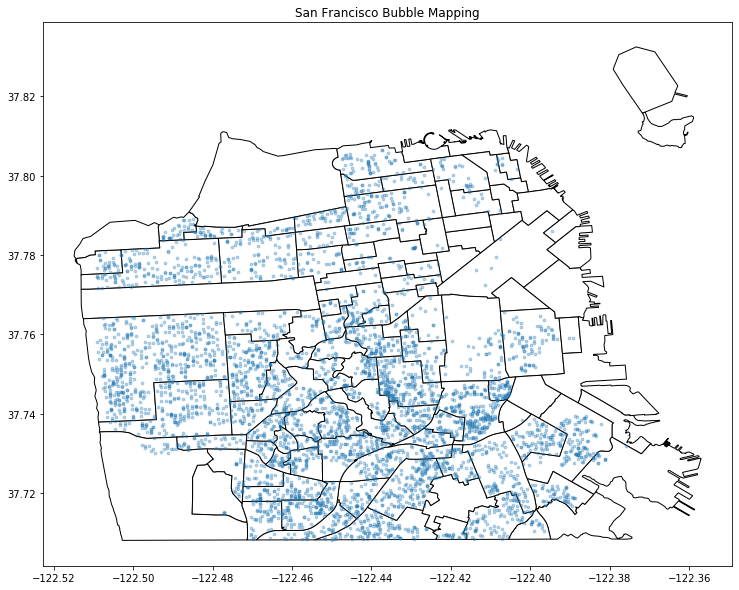

In [21]:
# fig, ax = plt.subplots(1, figsize=(13,10))
fig, ax = plt.subplots(1, figsize=(13,10))
sf_map = sf.plot(ax=ax, color='white', edgecolor='black')
geo_df.plot(ax=sf_map, marker="o", markersize=8, alpha=0.3)
ax.set_title("San Francisco Bubble Mapping")
plt.show()

# Avg. Log Error Diff by Neighborhood

In [36]:
# Spatial join
combined = geopandas.tools.sjoin(geo_df, sf, how='right')
combined['diff_log_error'].fillna(0)
neighborhood_counts = combined.groupby('name')['diff_log_error'].mean().reset_index()
neighborhood_counts.columns = ['name','avg_diff_log_error']
neighborhood_counts = neighborhood_counts.sort_values(by='avg_diff_log_error', ascending=False)

In [37]:
chloropleth_data = neighborhood_counts.merge(sf)
chloropleth_data = geopandas.GeoDataFrame(chloropleth_data, geometry='geometry')
chloropleth_data.crs = {'init': 'epsg:4326'}

AttributeError: 'PatchCollection' object has no property 'missing_kwds'

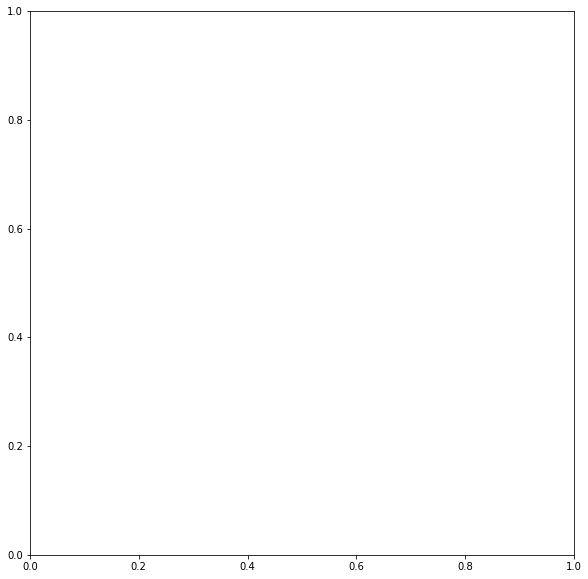

In [61]:
chloropleth_data.plot(column='avg_diff_log_error', cmap='coolwarm', figsize=(13,10),legend=True, missing_kwds={'color': 'lightgrey'}, legend_kwds={'label': "Difference in Log Error of Model Predictions with Location and Location Features",'orientation': "horizontal"})